In [1]:
from blackjackenv import BlackjackEnv
from collections import defaultdict
from qagent import QAgent

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.patches import Patch
from tqdm import tqdm

import gymnasium as gym


env = BlackjackEnv(sab=True)

In [2]:
# hyperparameters
learning_rate = 0.001
n_episodes = 100_000
start_epsilon = 1.0
epsilon_decay = start_epsilon / (n_episodes / 2)  # reduce the exploration over time
final_epsilon = 0.1
discount_factors = [0.95, 0.7, 0.5, 0.3, 0.05]

agents = []

for discount_factor in discount_factors:
    agent = QAgent(
        exp_policy="e_greedy",
        alpha=learning_rate,
        initial_epsilon=start_epsilon,
        epsilon_decay=epsilon_decay,
        final_epsilon=final_epsilon,
        gamma=discount_factor
    )
    agents.append(agent)

In [3]:
for agent in agents:
    print(agent)

In [4]:
envs = []
for agent in agents:
    env = BlackjackEnv(sab=True)
    env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)
    for episode in tqdm(range(n_episodes)):
        state, info = env.reset()
        done = False

        # play one episode
        while not done:
            action = agent.get_action(state)
            next_state, reward, terminated, truncated, info = env.step(action)

            # update the agent
            agent.update(state, action, reward, terminated, next_state)

            # update if the environment is done and the current obs
            done = terminated or truncated
            state = next_state

        agent.decay_epsilon()
    envs.append(env)

100%|██████████| 100000/100000 [00:44<00:00, 2237.07it/s]


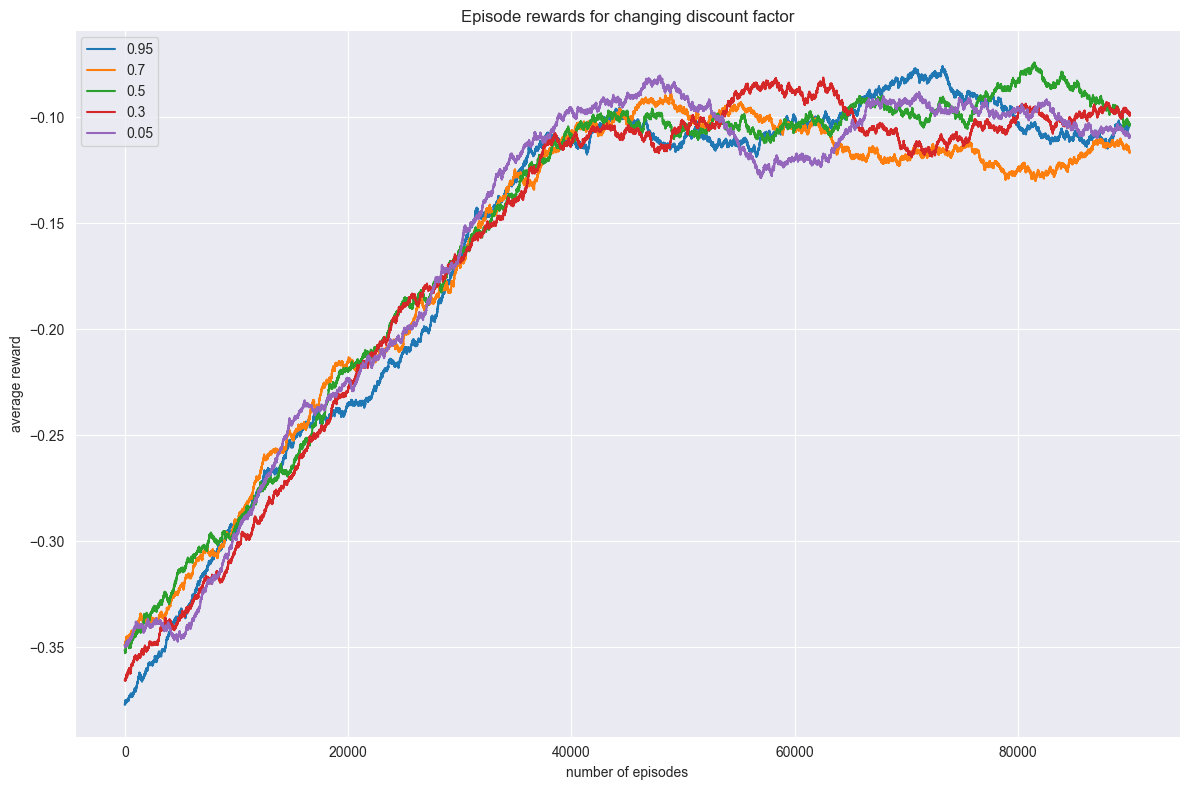

In [16]:
fig,ax = plt.subplots(figsize=(12,8))
ax.set_title("Episode rewards for changing discount factor")
i = 0

for env in envs:
    label = discount_factors[i]
    i = i+1
    rolling_length = 10000
    # compute and assign a rolling average of the data to provide a smoother graph
    reward_moving_average = (
        np.convolve(
            np.array(env.return_queue).flatten(), np.ones(rolling_length), mode="valid"
        )
        / rolling_length
    )
    ax.plot(range(len(reward_moving_average)), reward_moving_average, label = label)

plt.legend()   
plt.xlabel("number of episodes")
plt.ylabel("average reward")
plt.tight_layout()
plt.show()

In [20]:
# hyperparameters
learning_rates = [1,0.1,0.01,0.001,0.0001]
n_episodes = 1_000_000
start_epsilon = 1.0
epsilon_decay = start_epsilon / (n_episodes / 2)  # reduce the exploration over time
final_epsilon = 0.1
discount_factor = 0.95

agents = []

for learning_rate in learning_rates:
    agent = QAgent(
        exp_policy="e_greedy",
        alpha=learning_rate,
        initial_epsilon=start_epsilon,
        epsilon_decay=epsilon_decay,
        final_epsilon=final_epsilon,
        gamma=discount_factor
    )
    agents.append(agent)

In [21]:
envs = []
for agent in agents:
    env = BlackjackEnv(sab=True)
    env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)
    for episode in tqdm(range(n_episodes)):
        state, info = env.reset()
        done = False

        # play one episode
        while not done:
            action = agent.get_action(state)
            next_state, reward, terminated, truncated, info = env.step(action)

            # update the agent
            agent.update(state, action, reward, terminated, next_state)

            # update if the environment is done and the current obs
            done = terminated or truncated
            state = next_state

        agent.decay_epsilon()
    envs.append(env)

100%|██████████| 1000000/1000000 [05:31<00:00, 3016.30it/s]


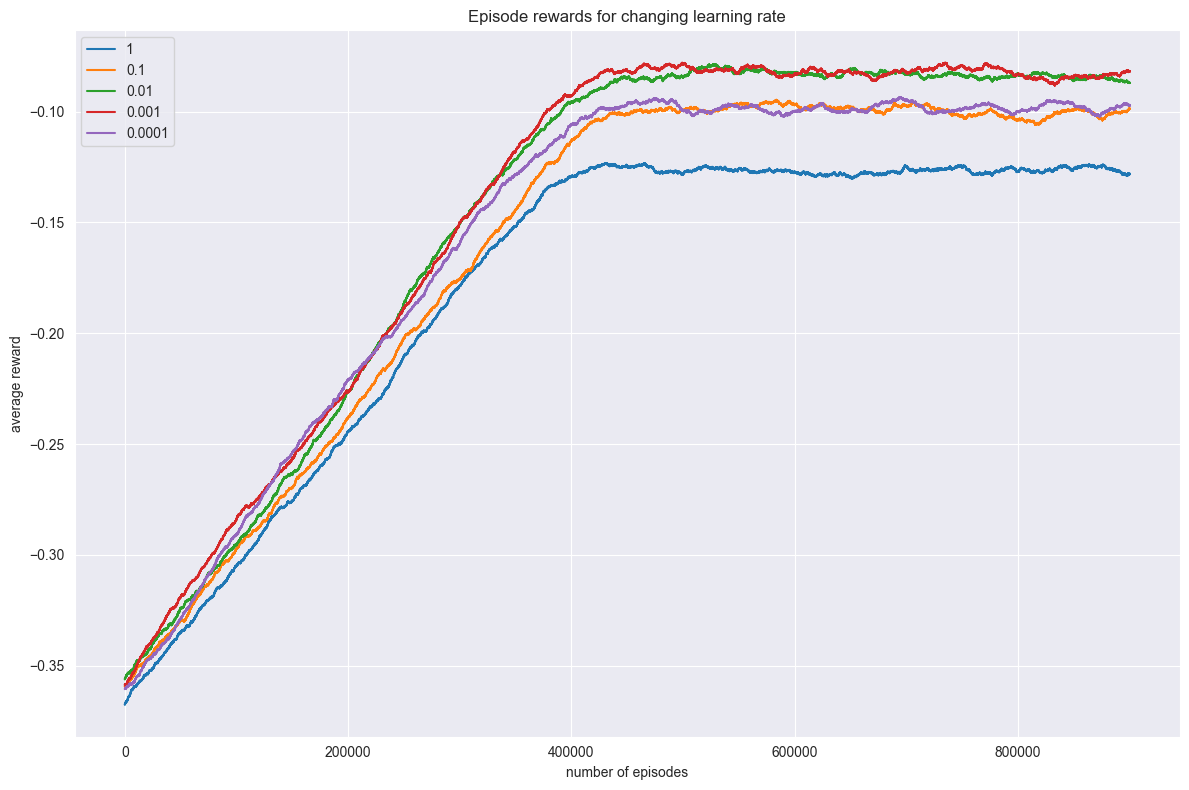

In [23]:
fig,ax = plt.subplots(figsize=(12,8))
ax.set_title("Episode rewards for changing learning rate")
i = 0

for env in envs:
    label = learning_rates[i]
    i = i+1
    rolling_length = 100_000
    # compute and assign a rolling average of the data to provide a smoother graph
    reward_moving_average = (
        np.convolve(
            np.array(env.return_queue).flatten(), np.ones(rolling_length), mode="valid"
        )
        / rolling_length
    )
    ax.plot(range(len(reward_moving_average)), reward_moving_average, label = label)

plt.legend()   
plt.xlabel("number of episodes")
plt.ylabel("average reward")
plt.tight_layout()
plt.show()